<a href="https://colab.research.google.com/github/Akash-infant/Taxi-trip-duration-prediction/blob/main/Using_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Approach - 2**

**Predicting trip duration using Gradient Boosting Tree Regressor**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e45729414872c8ebfa2f1ae8a0e01c78419ec87d32dd1ddd062a746c04dace9f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Importing necesscary packages

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from geopy.distance import geodesic
from datetime import datetime


In [3]:
conf = SparkConf().setAppName("TaxiDistanceForecasting-reg")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Importing Data

In [4]:
train_file = "/content/drive/My Drive/Taxi Demand/train.csv"
test_file = "/content/drive/My Drive/Taxi Demand/test.csv"



In [5]:
train_df = spark.read.csv(train_file, header=True)
test_df = spark.read.csv(test_file,header=True)

In [6]:
train_rows = train_df.count()
train_rows

1458644

In [7]:
test_rows=test_df.count()
test_rows

625134

In [8]:
train_df.show(5)
test_df.show(5)

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

Data pre-processing

In [9]:
# Checking for null values

from pyspark.sql.functions import isnull, count, when


missing_values_expr = [count(when(isnull(c), c)).alias(c) for c in train_df.columns]


missing_values_df = train_df.agg(*missing_values_expr)

missing_values_df.show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



Feature engineering and EDA

In [10]:
@udf(returnType=FloatType())
def get_distance_udf(source_lat, source_long, dest_lat, dest_long):
    return geodesic((source_lat, source_long), (dest_lat, dest_long)).miles

# creating new column "distance"  - calculated using geodesic library (both in train and test)
train_df = train_df.withColumn("distance", get_distance_udf("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))

In [11]:
test_df = test_df.withColumn("distance", get_distance_udf("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))
test_df.show(5)

+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+
|       id|vendor_id|    pickup_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag| distance|
+---------+---------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+---------+
|id3004672|        1|2016-06-30 23:59:58|              1|-73.988128662109375|40.732028961181641| -73.99017333984375|40.756679534912109|                 N|1.7043358|
|id3505355|        1|2016-06-30 23:59:53|              1|-73.964202880859375| 40.67999267578125|-73.959808349609375|40.655403137207031|                 N|1.7123582|
|id1217141|        1|2016-06-30 23:59:47|              1|  -73.9974365234375|40.737583160400391|-73.986160278320312|40.729522705078125|                 N|0.8122017|
|id2150126

In [12]:
# dropping ID from both train and test because it is unique and not useful to our result
train_df = train_df.select([col(column) for column in train_df.columns if column != "id"])


test_df = test_df.select([col(column) for column in test_df.columns if column != "id"])

In [13]:
vendor_id_counts = train_df.groupBy("vendor_id").count().orderBy("count", ascending=False)

# Show the result
vendor_id_counts.show()

+---------+------+
|vendor_id| count|
+---------+------+
|        2|780302|
|        1|678342|
+---------+------+



In [14]:
passenger_count_train_counts = train_df.groupBy("passenger_count").count().orderBy("count", ascending=False)

# Show the result for train_df
passenger_count_train_counts.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|1033540|
|              2| 210318|
|              5|  78088|
|              3|  59896|
|              6|  48333|
|              4|  28404|
|              0|     60|
|              7|      3|
|              9|      1|
|              8|      1|
+---------------+-------+



In [15]:
from pyspark.sql.functions import col, hour, minute, dayofweek, month
train_df = train_df.withColumn("pickup_datetime", col("pickup_datetime").cast("timestamp"))
test_df = test_df.withColumn("pickup_datetime", col("pickup_datetime").cast("timestamp"))

# Extract hour, minute, minute_oftheday, day_week, and month from "pickup_datetime" for train_df
train_df = train_df.withColumn("hour", hour("pickup_datetime"))
train_df = train_df.withColumn("minute", minute("pickup_datetime"))
train_df = train_df.withColumn("minute_oftheday", col("hour") * 60 + col("minute"))
train_df = train_df.withColumn("day_week", dayofweek("pickup_datetime"))
train_df = train_df.withColumn("month", month("pickup_datetime"))

# Extract hour, minute, minute_oftheday, day_week, and month from "pickup_datetime" for test_df
test_df = test_df.withColumn("hour", hour("pickup_datetime"))
test_df = test_df.withColumn("minute", minute("pickup_datetime"))
test_df = test_df.withColumn("minute_oftheday", col("hour") * 60 + col("minute"))
test_df = test_df.withColumn("day_week", dayofweek("pickup_datetime"))
test_df = test_df.withColumn("month", month("pickup_datetime"))

In [16]:
#since the date feature is a string data it cannot be processed,So we have extracted the data from it and dropping the column
train_df = train_df.drop("pickup_datetime", "dropoff_datetime")

test_df = test_df.drop("pickup_datetime")

In [17]:
from pyspark.sql.functions import when



# Replace 'N' with 0 and 'Y' with 1 in the train data -> ENCODING CATEGORICAL VALUES
train_df = train_df.withColumn('store_and_fwd_flag', when(col('store_and_fwd_flag') == 'N', 0).otherwise(1))

train_df.show(5)

# Replace 'N' with 0 and 'Y' with 1 in the test data
test_df = test_df.withColumn('store_and_fwd_flag', when(col('store_and_fwd_flag') == 'N', 0).otherwise(1))

# Show the updated test DataFrame
test_df.show(5)


+---------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+----+------+---------------+--------+-----+
|vendor_id|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration| distance|hour|minute|minute_oftheday|day_week|month|
+---------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+---------+----+------+---------------+--------+-----+
|        2|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 0|          455|0.9334063|  17|    24|           1044|       2|    3|
|        1|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 0|          663|1.1238492|   0|    43|             43|       1|    6|
|        2|              1|-73.979026794

In [18]:
from pyspark.sql.functions import col

# Convert string columns to integer
train_df = train_df.withColumn('vendor_id', col('vendor_id').cast('int'))
train_df = train_df.withColumn('passenger_count', col('passenger_count').cast('int'))
train_df = train_df.withColumn('pickup_longitude', col('pickup_longitude').cast('int'))
train_df = train_df.withColumn('pickup_latitude', col('pickup_latitude').cast('int'))
train_df = train_df.withColumn('dropoff_longitude', col('dropoff_longitude').cast('int'))
train_df = train_df.withColumn('dropoff_latitude', col('dropoff_latitude').cast('int'))
train_df = train_df.withColumn('trip_duration', col('trip_duration').cast('int'))

# Show the updated DataFrame schema
train_df.printSchema()


root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: integer (nullable = true)
 |-- pickup_latitude: integer (nullable = true)
 |-- dropoff_longitude: integer (nullable = true)
 |-- dropoff_latitude: integer (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = false)
 |-- trip_duration: integer (nullable = true)
 |-- distance: float (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- minute_oftheday: integer (nullable = true)
 |-- day_week: integer (nullable = true)
 |-- month: integer (nullable = true)



In [19]:
# Convert string columns to integer
test_df = test_df.withColumn('vendor_id', col('vendor_id').cast('int'))
test_df = test_df.withColumn('passenger_count', col('passenger_count').cast('int'))
test_df = test_df.withColumn('pickup_longitude', col('pickup_longitude').cast('int'))
test_df = test_df.withColumn('pickup_latitude', col('pickup_latitude').cast('int'))
test_df = test_df.withColumn('dropoff_longitude', col('dropoff_longitude').cast('int'))
test_df = test_df.withColumn('dropoff_latitude', col('dropoff_latitude').cast('int'))


test_df.printSchema()


root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: integer (nullable = true)
 |-- pickup_latitude: integer (nullable = true)
 |-- dropoff_longitude: integer (nullable = true)
 |-- dropoff_latitude: integer (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = false)
 |-- distance: float (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- minute_oftheday: integer (nullable = true)
 |-- day_week: integer (nullable = true)
 |-- month: integer (nullable = true)



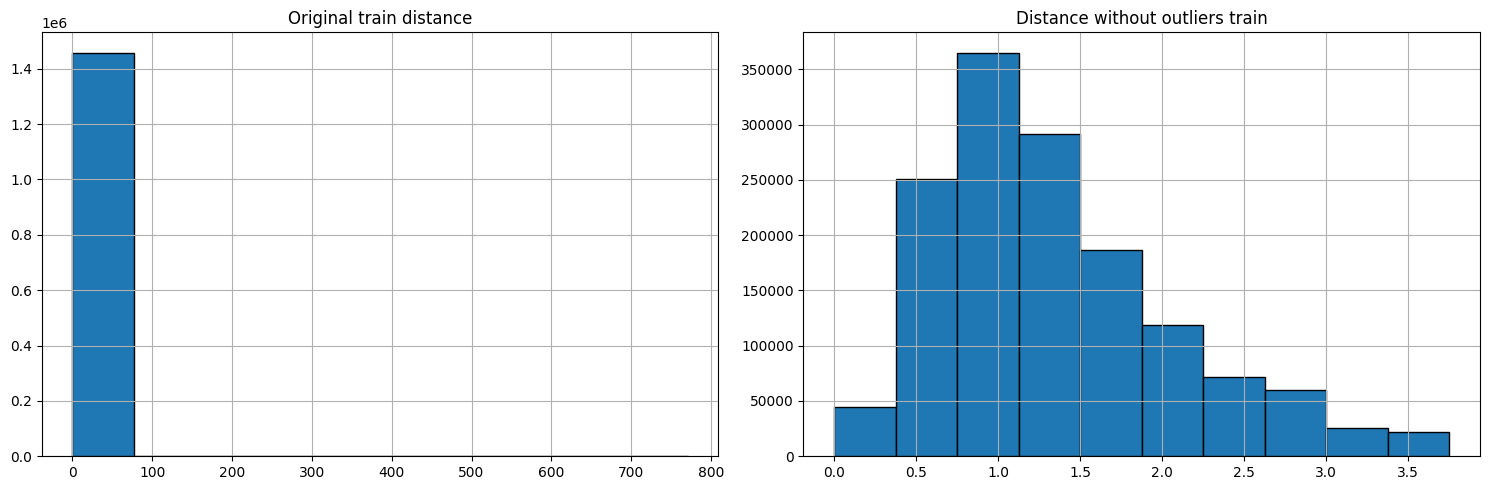

In [24]:
from pyspark.sql.functions import  log2
# Copy DataFrame
train_f = train_df

# Convert distance to log2
train_f = train_f.withColumn("distance", log2(col("distance") + 1))

# Calculate mean and standard deviation for train_df
mean_distance = train_f.agg({"distance": "mean"}).collect()[0][0]
sd_distance = train_f.agg({"distance": "stddev"}).collect()[0][0]
lower_bound_distance = mean_distance - (3 * sd_distance)
upper_bound_distance = mean_distance + (3 * sd_distance)

# Filter out the outliers
train_f = train_f.filter((col("distance") > lower_bound_distance) & (col("distance") < upper_bound_distance))

# Convert PySpark DataFrame to Pandas for visualization
train_pd = train_f.select("distance").toPandas()

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
train_df.select("distance").toPandas().hist(ax=axes[0], edgecolor="black")
train_pd.hist(ax=axes[1], edgecolor="black")

axes[0].set_title("Original train distance")
axes[1].set_title("Distance without outliers train")
plt.tight_layout()
plt.show()

In [25]:
# after apply log in distance it is normally distributed and Skewness Reduction
from pyspark.sql.functions import col, monotonically_increasing_id

train_df = train_df.withColumn("index", monotonically_increasing_id())
train_df = train_df.select("*", (col("index") + 1).alias("index")).drop("index")


test_df = test_df.withColumn("distance", log2(col("distance") + 1))

# Show the modified DataFrames
train_df.show()
test_df.show()

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+----------+----+------+---------------+--------+-----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|  distance|hour|minute|minute_oftheday|day_week|month|
+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+----------+----+------+---------------+--------+-----+
|        2|              1|             -73|             40|              -73|              40|                 0|          455| 0.9334063|  17|    24|           1044|       2|    3|
|        1|              1|             -73|             40|              -73|              40|                 0|          663| 1.1238492|   0|    43|             43|       1|    6|
|        2|              1|             -73|             40|              -74|       

In [26]:
# removing "minute_oftheday" due to no correlation with the duration

train_df = train_df.drop('minute_oftheday')

test_df = test_df.drop('minute_oftheday')

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

feature_cols = ["vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "distance", "hour", "minute", "day_week", "month"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="trip_duration", maxIter=10, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, gbt])

# Fit the model
model_pipeline = pipeline.fit(train_df)



In [31]:
test_predictions = model_pipeline.transform(test_df)

# Select the columns of interest (including predicted 'trip_duration')
result = test_predictions.select("vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude",
                                 "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag", "distance",
                                 "hour", "minute", "day_week", "month", "prediction")

# the predicted trip duartion values for test dataset
result.show()



+---------+---------------+----------------+---------------+-----------------+----------------+------------------+------------------+----+------+--------+-----+------------------+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|          distance|hour|minute|day_week|month|        prediction|
+---------+---------------+----------------+---------------+-----------------+----------------+------------------+------------------+----+------+--------+-----+------------------+
|        1|              1|             -73|             40|              -73|              40|                 0| 1.435274244660843|  23|    59|       5|    6| 753.5106447792517|
|        1|              1|             -73|             40|              -73|              40|                 0|1.4395477358564481|  23|    59|       5|    6| 753.5106447792517|
|        1|              1|             -73|             40|              -73|              40|     